# **Model Selection and Model Improvement**
<hr>

| Name | AdminNo |
| :--: | :-----: |
| Goh Pin Pin Isaac     | P2317623 |
| Adam Bin Roslan       | P2317425 |
| Choy Jee Hung Caleb   | P2341475 |
| Thor Hui Qin          | P2309219 |

- **Class:** DAAA/FT/2A/23
- **Module Code:** ST1508 Practical AI
<hr>

# **Notebook Objective**
Our model should output the `Probability % of Fraud Order`<br>

Matrix used:
- `Recall` (Sensitivity or True Positive Rate):
    - Measures the proportion of actual fraud cases that the model successfully identifies as fraud.
    - Key Question: How many fraudulent orders are we catching?
    - Reason: We are concentrating on the accuracy of catching fraud orders

Select a model by comparing their performances using correlation matrix, we will choose the model that best fits our data (Fraud Detection). Once the best-performing model has been chosen, we will adjust its hyperparameters to further maximize its performance. We will use MLflow to monitor our tests and Dask to speed up our calculations. Deploy final model for GUI.

<br>
<hr>

# 📊**Machine Learning Workflow with MLflow Integration and Dask-ML**
This notebook demonstrates a machine learning workflow for detecting fraudulent transactions. We'll:
1. **Preprocess the data** to handle numerical and categorical features.
2. **Split the data** into training and testing sets, using half of the dataset for training.
3. **Train and evaluate multiple models**, while tracking results with MLflow.
4. **Compare model performance** to identify the best-performing model.

Key Enhancements with Dask-ML
1. **Dask-Optimized Preprocessing** (dask_ml.preprocessing)
2. **Dask-Parallelized Model Training** (dask_ml.wrappers.ParallelPostFit)
3. **Dask-Optimized Hyperparameter Tuning** (dask_ml.model_selection.GridSearchCV)
4. **Lazy Execution** (minimizing .compute() calls)

<br>
<hr>

# **Importing Libaries**

In [1]:
# Importing Modules
import pandas as pd
import numpy as np
import joblib
import pickle
from tqdm import tqdm
from sqlalchemy import create_engine, text
from datetime import datetime
from scipy.stats import randint, uniform
import os

# Data Preprocessing
import dask.dataframe as dd
from dask.distributed import Client, progress
from dask import config
import dask.array as da
import dask_ml.model_selection as dcv
import dask_ml.preprocessing as dpp
from dask_ml.wrappers import ParallelPostFit

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn 
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, learning_curve, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,  accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTEENN

# MLflow
from mlflow.tracking import MlflowClient
import mlflow
import mlflow.sklearn

# Warnings
import warnings
warnings.filterwarnings("ignore")

<hr>

# **Extract, Load & Transform**
<hr>

In [2]:
server = 'PINPINPC\\SQLEXPRESS'
database = 'SP-buy'
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL+Server')

# Function to retrieve data from a specific table and return a DataFrame
def get_table_data(table_name):
    connection = engine.connect()
    query = text(f'SELECT * FROM {table_name}')
    result = connection.execute(query)
    df = pd.DataFrame(data=result.fetchall(), columns=result.keys())
    connection.close()
    return df

# Retrieve data from each table
customers_df = get_table_data('customers')
orders_df = get_table_data('orders')
order_labels_df = get_table_data('order_labels')

In [3]:
# ===================== Customer Features Data =====================
customers_df['total_payment_last_50days'] = pd.to_numeric(customers_df['total_payment_last_50days'], errors='coerce')
customers_df['mobile_verified'] = customers_df['mobile_verified'].map({'True': True, 'False': False})
customers_df['mobile_verified'] = customers_df['mobile_verified'].astype(bool)
customers_df['country_code'] = customers_df['country_code'].astype('category')
customers_df['customer_id'] = customers_df['customer_id'].astype('category')
customers_df['num_orders_last_50days'] = customers_df['num_orders_last_50days'].astype('int16')
customers_df['num_cancelled_orders_last_50days'] = customers_df['num_cancelled_orders_last_50days'].astype('int16')
customers_df['num_refund_orders_last_50days'] = customers_df['num_refund_orders_last_50days'].astype('int16')
customers_df['num_associated_customers'] = customers_df['num_associated_customers'].astype('int16')
customers_df['total_payment_last_50days'] = customers_df['total_payment_last_50days'].astype('float32')

# ===================== Order Features Data =====================
orders_df['order_value'] = pd.to_numeric(orders_df['order_value'], errors='coerce')
orders_df['refund_value'] = pd.to_numeric(orders_df['refund_value'], errors='coerce')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], errors='coerce')
orders_df['country_code'] = orders_df['country_code'].astype('category')
orders_df['order_id'] = orders_df['order_id'].astype('category')
orders_df['collect_type'] = orders_df['collect_type'].astype('category')
orders_df['payment_method'] = orders_df['payment_method'].astype('category')
orders_df['num_items_ordered'] = orders_df['num_items_ordered'].astype('int16')
orders_df['order_value'] = orders_df['order_value'].astype('float32')
orders_df['refund_value'] = orders_df['refund_value'].astype('float32')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date']).dt.normalize()

# ===================== Order Label Data ====================
order_labels_df['country_code'] = order_labels_df['country_code'].astype('category')
order_labels_df['order_id'] = order_labels_df['order_id'].astype('category')
order_labels_df['customer_id'] = order_labels_df['customer_id'].astype('category')

### **Feature Engineering**
<hr>

##### Grouping Payment Methods
- Group 1: `Credit/Debit Card Payments`
    - cybersource creditcard: 324,605
    - credit card: 270,693
    - generic creditcard: 172,853
    - cybersource applepay: 1,359
- Group 2: `Online Banking`
    - razer online banking: 298,750
    - xendit directdebit: 8
- Group 3: `Digital Wallets`
    - antfinancial gcash: 246,217
    - antfinancial tng: 51,773
    - antfinancial bkash: 42,249
    - antfinancial truemoney: 22,060
    - adyen hpp boost: 14,608
    - jazzcash wallet: 5,846
    - paypal: 852
- Group 4: `Buy Now, Pay Later`
    - invoice: 4,912
- Group 5: `Preloaded Balance`
    - balance: 61,859
- Group 6: `Cash/Alternative Payments`
    - payment on delivery: 747,245
    - no payment: 1,624
- Group 7: `Other Payment Gateways`
    - adyen hpp molpay: 1,883


In [4]:
payment_groups = {
    # Credit/Debit Card Payments
    "cybersource creditcard": "Credit/Debit Card Payments",
    "credit card": "Credit/Debit Card Payments",
    "generic creditcard": "Credit/Debit Card Payments",
    "cybersource applepay": "Credit/Debit Card Payments",
    
    # Online Banking
    "razer online banking": "Online Banking",
    "xendit directdebit": "Online Banking",
    
    # Digital Wallets
    "antfinancial gcash": "Digital Wallets",
    "antfinancial tng": "Digital Wallets",
    "antfinancial bkash": "Digital Wallets",
    "antfinancial truemoney": "Digital Wallets",
    "adyen hpp boost": "Digital Wallets",
    "jazzcash wallet": "Digital Wallets",
    "paypal": "Digital Wallets",
    
    # Buy Now, Pay Later
    "invoice": "Buy Now, Pay Later",
    
    # Preloaded Balance
    "balance": "Preloaded Balance",
    
    # Cash/Alternative Payments
    "payment on delivery": "Cash/Alternative Payments",
    "no payment": "Cash/Alternative Payments",
    
    # Other Payment Gateways
    "adyen hpp molpay": "Other Payment Gateways"
}

# Add a new column for payment groups
orders_df['payment_group'] = orders_df['payment_method'].map(payment_groups)

### **Merge Dataset**
<hr>

In [5]:
pre_dataset = customers_df.merge(order_labels_df, left_on=['country_code', 'customer_id'], right_on=['country_code', 'customer_id'], how='inner')
sp_buy_dataset = pre_dataset.merge(orders_df, left_on=['country_code', 'order_id'], right_on=['country_code', 'order_id'], how='inner')
sp_buy_dataset

,country_code,customer_id,mobile_verified,num_orders_last_50days,num_cancelled_orders_last_50days,num_refund_orders_last_50days,total_payment_last_50days,num_associated_customers,first_order_datetime,order_id,is_fraud,collect_type,payment_method,order_value,num_items_ordered,refund_value,order_date,payment_group
0,BD,a0afp7hz,True,19,0,0,135.929993,3,2015-12-01 14:06:14,u2qo-f2n5,True,delivery,credit card,4.410000,5,0.00,2023-04-08,Credit/Debit Card Payments
1,BD,a0akr6uc,True,31,1,0,312.239990,2,2017-09-13 08:26:51,orca-073r,False,delivery,payment on delivery,1.230000,3,0.53,2023-02-17,Cash/Alternative Payments
2,BD,a0aya4cb,True,34,0,0,381.790009,3,2016-02-29 13:45:03,u7ox-r80t,False,delivery,payment on delivery,5.670000,3,2.03,2023-04-28,Cash/Alternative Payments
3,BD,a0bwh4cs,True,51,0,0,611.809998,1,2015-12-16 16:08:34,fgxo-yub4,False,delivery,credit card,4.870000,7,0.00,2023-04-03,Credit/Debit Card Payments
4,BD,a0bwh4cs,True,51,0,0,611.809998,1,2015-12-16 16:08:34,ta7z-z366,False,delivery,antfinancial bkash,7.550000,3,3.92,2023-05-08,Digital Wallets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263675,TH,z9vaf2ti,True,6,0,0,217.619995,2,2015-10-20 11:23:09,w1ep-tjlo,False,delivery,cybersource creditcard,10.580000,2,11.48,2023-04-27,Credit/Debit Card Payments
2263676,TH,z9xql6cq,True,5,0,0,175.190002,1,2015-08-18 15:10:01,d9dy-0mpg,False,delivery,cybersource creditcard,15.800000,2,0.00,2022-11-13,Credit/Debit Card Payments
2263677,TH,z9xwq4yl,True,1,0,0,28.570000,2,2020-09-26 13:20:08,a6kp-u64i,False,delivery,cybersource creditcard,4.340000,1,0.00,2023-05-09,Credit/Debit Card Payments
2263678,TH,z9zra5st,True,39,0,0,677.440002,1,2017-03-27 12:23:57,d0ig-4eca,False,delivery,cybersource creditcard,5.800000,2,5.80,2023-02-06,Credit/Debit Card Payments


<hr>

# 📊**Handling Outliers** (`IsolationForest`)
- `Isolation Forest` is the best choice for large fraud detection datasets
    - It is highly scalable and efficient for big data.
    - It works well with high-dimensional data.
    - It detects anomalies based on their separation from the normal data distribution.
    - It does not require the dataset to be labeled.
<hr>

In [6]:
# Select numerical columns for analysis
numerical_cols = [
    'num_orders_last_50days',
    'num_cancelled_orders_last_50days',
    'num_refund_orders_last_50days',
    'total_payment_last_50days',
    'num_associated_customers',
    'order_value',
    'num_items_ordered',
    'refund_value'
]

# Extract numerical data
df_numeric = sp_buy_dataset[numerical_cols].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

In [7]:
# Initialize IsolationForest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
Outliers = pd.DataFrame()

# Fit the model and predict
iso_forest.fit(X_scaled)
y_pred = iso_forest.predict(X_scaled)

# -1 for outliers, 1 for inliers
df_numeric['anomaly'] = y_pred
outliers_subset = sp_buy_dataset[y_pred == -1].copy()
Outliers = pd.concat([Outliers, outliers_subset], axis=0, ignore_index=True)
print(f"Total outlier detections (including multiple detections for the same data point): {Outliers.shape[0]}")

Total outlier detections (including multiple detections for the same data point): 113183


In [8]:
sp_buy_dataset_inliers = sp_buy_dataset[y_pred == 1]
print(f"We are left with ({sp_buy_dataset_inliers.shape[0]}) inliers in the dataset")

We are left with (2150497) inliers in the dataset


<hr>

# 🚀 **Dask Client & MLflow Environment**
**Dask** is a parallel computing library that scales Python workflows, especially for big data and machine learning. It provides:
- Dask DataFrame: Works like Pandas but operates on large datasets by partitioning them across multiple cores or machines.
- Dask Array: Similar to NumPy but supports parallel computations on large arrays.

**MLflow** is an open-source platform for managing the machine learning lifecycle. It provides:
- Tracking – Logs experiments, parameters, metrics, and artifacts.
- Projects – Standardizes packaging for reproducible runs.
- Models – Handles model versioning and deployment.
<hr>

In [9]:
sp_buy_dataset_dask = dd.from_pandas(sp_buy_dataset_inliers, npartitions=2)
sp_buy_dataset_dask.info(memory_usage='deep')

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 18 entries, country_code to payment_group
dtypes: category(1), category(1), category(1), datetime64[ns](2), bool(2), float32(3), int16(5), string(3)
memory usage: 233.7 MB


In [10]:
# Instantiate Dask Client
client = Client()
print(client)
client.amm.start()
config.set({'interface': 'lo'})

<Client: 'tcp://127.0.0.1:62664' processes=4 threads=16, memory=15.74 GiB>


In [11]:
# Set MLflow experiment
mlflow.set_experiment("Fraud Detection Models with Dask")

<Experiment: artifact_location='file:///c:/POLY/Y2S2/PAI/CA2/Modelling/mlruns/415996057174830531', creation_time=1739091878557, experiment_id='415996057174830531', last_update_time=1739091878557, lifecycle_stage='active', name='Fraud Detection Models with Dask', tags={}>

<hr>

# ✂ **Splitting the Data with Dask**
We'll split the dataset into training and testing sets, using 80% of the dataset for training.
<hr>

In [12]:
# Splitting the dataset into Features and Target
features = [
    'country_code', 'customer_id', 'mobile_verified',
    'num_orders_last_50days', 'num_cancelled_orders_last_50days',
    'num_refund_orders_last_50days', 'total_payment_last_50days',
    'num_associated_customers', 'first_order_datetime', 'order_id',
    'collect_type', 'payment_method', 'order_value',
    'num_items_ordered', 'refund_value', 'order_date', 'payment_group'
]
target = 'is_fraud'

X = sp_buy_dataset_dask[features]
y = sp_buy_dataset_dask[target]

# Convert Dask DataFrame to Pandas for stratified sampling
X_pd = X.compute()  # Convert Dask DataFrame to Pandas
y_pd = y.compute().astype(int)  # Convert Dask Series to Pandas

# Splitting the dataset into the Training set and Test set (80% training and 20% testing)
X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
    X_pd, y_pd, test_size=0.8, stratify=y_pd, random_state=42
)

print(f"X train shape: {X_train_pd.shape}")
print(f"y train shape: {y_train_pd.shape}")
print(f"X test shape: {X_test_pd.shape}")
print(f"y test shape: {y_test_pd.shape}")

# Convert back to Dask DataFrame
X_train = dd.from_pandas(X_train_pd, npartitions=4)
X_test = dd.from_pandas(X_test_pd, npartitions=4)
y_train = dd.from_pandas(y_train_pd, npartitions=4)
y_test = dd.from_pandas(y_test_pd, npartitions=4)

X train shape: (430099, 17)
y train shape: (430099,)
X test shape: (1720398, 17)
y test shape: (1720398,)


<hr>

# 🛠 **Preprocessing Pipelines**
We'll define separate pipelines for numerical and categorical features. These pipelines will handle missing values, scaling, and encoding.
<hr>

In [13]:
def prepare_data(X_train_pd, X_test_pd, y_train_pd, y_test_pd):
    # Define feature groups
    numerical_features = [
        'num_orders_last_50days', 
        'num_cancelled_orders_last_50days', 
        'num_refund_orders_last_50days', 
        'total_payment_last_50days', 
        'num_associated_customers', 
        'order_value', 
        'num_items_ordered', 
        'refund_value'
    ]

    categorical_features = [
        'country_code', 
        'collect_type', 
        'payment_group'
    ]

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
    )

    # Fit and transform the training data
    X_train_transformed = preprocessor.fit_transform(X_train_pd)
    X_test_transformed = preprocessor.transform(X_test_pd)
    
    # Get feature names after transformation
    numeric_features = numerical_features
    categorical_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(categorical_features_encoded)
    
    # Convert to DataFrame with proper column names
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
    
    return X_train_transformed, X_test_transformed, y_train_pd, y_test_pd

In [14]:
X_train_transformed, X_test_transformed, y_train, y_test = prepare_data(
    X_train_pd, X_test_pd, y_train_pd, y_test_pd
)

<hr>

# 💨**Imbalanced Classes** (`SMOTEENN`)
- `SMOTEENN` is the best technique for our dataset (**From our AdvancedDataProcessing Research**):
    - It provides the most balanced performance across all metrics
    - Shows excellent generalization (similar test and train scores)
    - Achieves perfect scores in several key metrics while maintaining high performance in others
    - Processing time (5.060368) is reasonable compared to other high-performing techniques
    - Shows no significant weaknesses across any metrics
<hr>

In [15]:
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train_transformed, y_train)

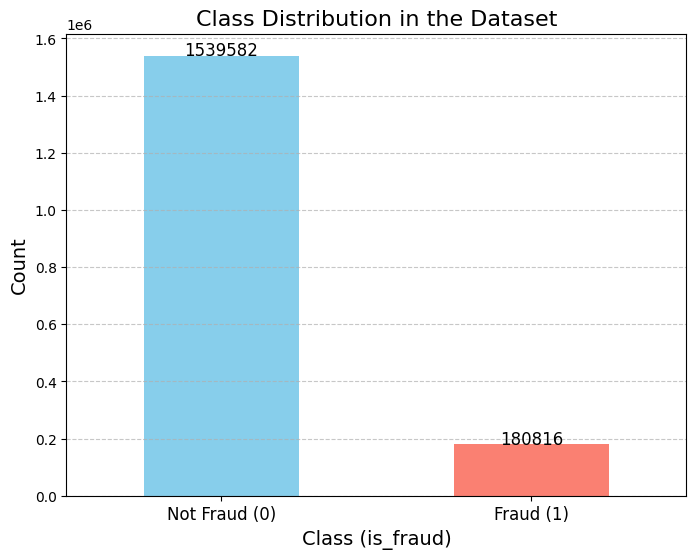

In [91]:
# Count the number of occurrences for each class in the 'is_fraud' column
class_counts = y_test.value_counts()

# Plot a bar chart to visualize class imbalance
plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Add the counts on top of the bars
for i, count in enumerate(class_counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.title('Class Distribution in the Dataset', fontsize=16)
plt.xlabel('Class (is_fraud)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Fraud (0)', 'Fraud (1)'], rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<hr>

# 🧠 **Model Training with Dask & MLflow**
The `train_and_evaluate_model` function:
1. Trains the model using a pipeline with preprocessing.
2. Evaluates the model on the test set.
3. Logs metrics, confusion matrices, and the trained model to MLflow.
<hr>

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(4,3))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [17]:
def evaluate_models(X_train, y_train, models, scoring_methods):
    outputs = []
    
    # Create progress bar
    with tqdm(total=len(models), desc="Training Models") as pbar:
        for model_name, estimator in models:
            with mlflow.start_run(run_name=model_name):
                # Log model parameters
                params = estimator.get_params()
                mlflow.log_params(params)
                
                # Create and plot learning curve
                cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
                fig = plot_learning_curve(
                    estimator, model_name, X_train, y_train, 
                    (0, 1.01), cv=cv, n_jobs=4
                )
                
                # Save plot to file and log with MLflow
                plot_path = f"./LearningCurves/{model_name}_learning_curve.png"
                plt.savefig(plot_path)
                mlflow.log_artifact(plot_path)
                plt.close()
                
                # Perform cross-validation
                try:
                    scores = cross_validate(
                        estimator,
                        X_train,
                        y_train,
                        scoring=scoring_methods,
                        n_jobs=3,
                        verbose=0,
                        cv=10,
                        return_train_score=True
                    )
                    
                    # Calculate mean scores
                    mean_scores = pd.Series(scores, name=model_name).apply(np.mean)
                    outputs.append(mean_scores)
                    
                    # Log metrics to MLflow
                    for metric, value in mean_scores.items():
                        mlflow.log_metric(metric, value)
                    
                except Exception as e:
                    print(f"Error training {model_name}: {str(e)}")
                    continue
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({'Current Model': model_name})
    
    # Combine all results into a DataFrame
    results_df = pd.concat(outputs, axis=1).T
    
    # Style the results
    styled_results = results_df.style.apply(
        lambda x: ["background-color: red; color: white" if v else "" for v in x == x.min()]
    ).apply(
        lambda x: ["background-color: green; color: white" if v else "" for v in x == x.max()]
    )
    
    return styled_results, results_df

In [35]:
MODELS = [
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("LogisticRegression", LogisticRegression()),
    ("GaussianNB", GaussianNB()),
    ("GradientBoostingClassifier", GradientBoostingClassifier())
]

# Define scoring methods
scoring_methods = {
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Run evaluation
styled_results, raw_results = evaluate_models(X_resampled, y_resampled, MODELS, scoring_methods)
display(styled_results)

Training Models: 100%|██████████| 5/5 [41:41<00:00, 500.35s/it, Current Model=GradientBoostingClassifier]


,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DecisionTreeClassifier,3.914671,0.042501,0.977125,1.000000,0.976983,1.000000,0.979533,1.000000,0.978168,1.000000,0.976983,1.000000
RandomForestClassifier,77.305977,1.536439,0.989101,0.999999,0.988846,0.999999,0.993451,1.000000,0.989674,0.999999,0.999339,1.000000
LogisticRegression,3.762040,0.038094,0.933346,0.933358,0.932002,0.932014,0.956284,0.956302,0.938045,0.938057,0.981164,0.981183
GaussianNB,0.309328,0.100856,0.898118,0.898126,0.894025,0.894032,0.968005,0.968015,0.909313,0.909320,0.965676,0.965674
GradientBoostingClassifier,129.694972,0.209726,0.957674,0.958135,0.956742,0.957185,0.973598,0.974344,0.960411,0.960878,0.992632,0.992755


<u>**Observations:**</u>
- `RandomForestClassifier` shows the best overall performance with:
    - Highest test accuracy (0.989)
    - Highest balanced accuracy (0.989)
    - Perfect train accuracy (1.0)
    - Excellent ROC AUC scores (0.999)
    - However, it has the longest fit time (77.3 seconds)
- `DecisionTreeClassifier` also performs very well:
    - Good test accuracy (0.977)
    - Perfect train accuracy (1.0)
    - Fast fit time (3.91 seconds)
    - High ROC AUC (0.977)

<hr>

## 💪🏽**Model Improvement and Hyperparameter Tuning**

In this section, we perform hyperparameter tuning for three models—**Logistic Regression**, **Decision Tree**, and **Random Forest**—using **GridSearchCV**. GridSearchCV helps find the best combination of hyperparameters for each model by performing cross-validation.
<hr>

In [27]:
def hyperparameter_tuning(X_train, y_train, model, param_dist, model_name):
    with mlflow.start_run(run_name=f"{model_name}_hypertuning"):
        # Create RandomizedSearchCV object
        random_search = RandomizedSearchCV(
            model,
            param_distributions=param_dist,
            n_iter=3,  # Number of parameter settings sampled
            cv=5,
            scoring='recall',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        # Fit RandomizedSearchCV
        random_search.fit(X_train, y_train)
        
        # Log best parameters and scores
        mlflow.log_params(random_search.best_params_)
        mlflow.log_metric("best_score", random_search.best_score_)
        
        # Log all results
        results = pd.DataFrame(random_search.cv_results_)
        results.to_csv(f"./Hypertune/{model_name}_randomsearch_results.csv")
        mlflow.log_artifact(f"./Hypertune/{model_name}_randomsearch_results.csv")
        
        return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

In [ ]:
# Parameter distributions for RandomForestClassifier
rf_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(10, 100, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Parameter distributions for DecisionTreeClassifier
dt_param_dist = {
    'max_depth': [None] + list(range(10, 100, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}



# Perform hyperparameter tuning for both models
rf_model = RandomForestClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)

# Tune DecisionTreeClassifier
dt_best_model, dt_best_params, dt_best_score = hyperparameter_tuning(
    X_resampled, y_resampled, dt_model, dt_param_dist, "DecisionTree"
)

# # Tune RandomForestClassifier
rf_best_model, rf_best_params, rf_best_score = hyperparameter_tuning(
    X_resampled, y_resampled, rf_model, rf_param_dist, "RandomForest"
)

# Print results
print("\nBest RandomForest Parameters:", rf_best_params)
print("Best RandomForest Score:", rf_best_score)
print("\nBest DecisionTree Parameters:", dt_best_params)
print("Best DecisionTree Score:", dt_best_score)

<u>**Obseration**</u>
- Although both hypertuned models have a very high score of Recall, the model is heavily overfitted towards class 0 as seen from the confusion matrix<br>
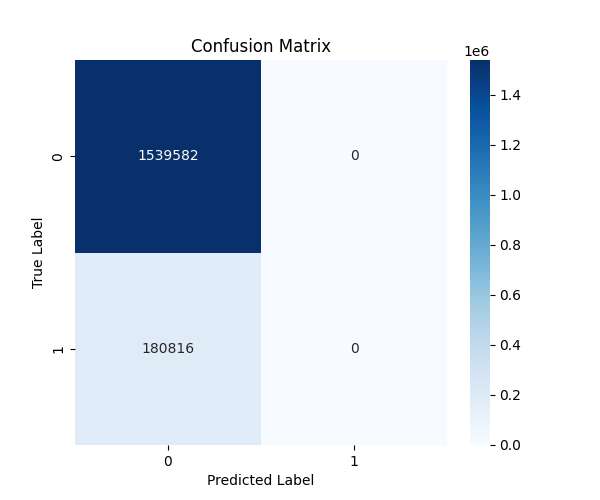
- Run time of RandomForest is 60 times SLOWER then Decision Tree
![WhatsApp Image 2025-02-13 at 01.40.55_269128c0.jpg](<attachment:WhatsApp Image 2025-02-13 at 01.40.55_269128c0.jpg>)

more ways to handle `severe class imbalance`:
- setting class_weight='balanced' in DecisionTreeClassifier()
- Instead of ShuffleSplit, try Stratified K-Fold (StratifiedKFold(n_splits=10)) to keep class distribution balanced in each fold.
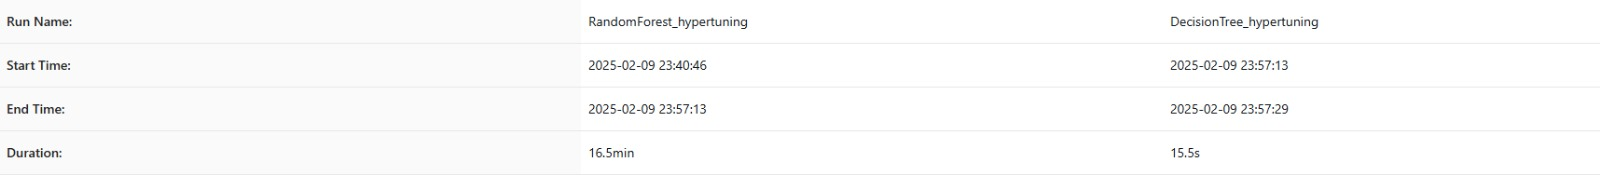

<hr>

## **Final Model**
<hr>

In [9]:
def preprocess_test_data(X_test):
    # Convert dask dataframe to pandas if needed
    if hasattr(X_test, 'compute'):
        X_test = X_test.compute()
    
    # Create one-hot encodings for categorical columns
    X_test_processed = X_test.copy()
    
    # One-hot encode country_code
    country_dummies = pd.get_dummies(X_test_processed['country_code'], prefix='country_code')
    
    # One-hot encode collect_type
    collect_type_dummies = pd.get_dummies(X_test_processed['collect_type'], prefix='collect_type')
    
    # One-hot encode payment_group
    payment_group_dummies = pd.get_dummies(X_test_processed['payment_group'], prefix='payment_group')
    
    # Select only numerical columns we need
    numerical_columns = [
        'num_orders_last_50days',
        'num_cancelled_orders_last_50days',
        'num_refund_orders_last_50days',
        'total_payment_last_50days',
        'num_associated_customers',
        'order_value',
        'num_items_ordered',
        'refund_value'
    ]
    
    # Create the final processed dataframe
    X_test_final = pd.concat([
        X_test_processed[numerical_columns],
        country_dummies,
        collect_type_dummies,
        payment_group_dummies
    ], axis=1)
    
    # Ensure columns match training data
    required_columns = [
        'num_orders_last_50days',
        'num_cancelled_orders_last_50days',
        'num_refund_orders_last_50days',
        'total_payment_last_50days',
        'num_associated_customers',
        'order_value',
        'num_items_ordered',
        'refund_value',
        'country_code_MY',
        'country_code_PH',
        'country_code_PK',
        'country_code_TH',
        'collect_type_pickup',
        'payment_group_Cash/Alternative Payments',
        'payment_group_Credit/Debit Card Payments',
        'payment_group_Digital Wallets',
        'payment_group_Online Banking',
        'payment_group_Other Payment Gateways',
        'payment_group_Preloaded Balance'
    ]
    
    # Add missing columns with zeros if they don't exist
    for col in required_columns:
        if col not in X_test_final.columns:
            X_test_final[col] = 0
    
    # Select only the required columns in the correct order
    X_test_final = X_test_final[required_columns]
    
    return X_test_final

In [22]:
def plot_and_log_confusion_matrix(y_true, y_pred, save_path):
    """Generates, saves, and logs confusion matrix in MLflow."""
    cm = confusion_matrix(y_true, y_pred)

    # Create the plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # Save the figure
    plt.savefig(save_path)
    plt.close()

    # Log artifact to MLflow
    mlflow.log_artifact(save_path)

    return cm

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(4,3))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt


def train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test, best_params):
    # Create directories if they don't exist
    os.makedirs("./LearningCurves", exist_ok=True)
    os.makedirs("./PickleFiles", exist_ok=True)
    os.makedirs("./Plots", exist_ok=True)

    with mlflow.start_run(run_name="Final_Model_DecisionTree"):
        # Preprocess test data to match training data format
        X_test_processed = preprocess_test_data(X_test)
        
        model = DecisionTreeClassifier(**best_params)
        # Log model parameters
        mlflow.log_params(best_params)
        
        # Create learning curve plot
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        fig = plot_learning_curve(model, "DecisionTreeClassifier", X_train, y_train, (0, 1.01), cv=cv, n_jobs=4)
        
        # Save plot to file and log with MLflow
        plot_path = "./LearningCurves/FinalModel_learning_curve.png"
        plt.savefig(plot_path)
        mlflow.log_artifact(plot_path)
        plt.close()
        
        # Perform cross-validation
        scoring_methods = {
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc'
        }
        
        scores = cross_validate(model, X_train, y_train, scoring=scoring_methods, n_jobs=3, verbose=0, cv=10, return_train_score=True)
        
        # Calculate mean scores
        mean_scores = {metric: np.mean(values) for metric, values in scores.items()}
        
        # Log metrics to MLflow
        for metric, value in mean_scores.items():
            mlflow.log_metric(metric, value)
        
        # Train final model
        model.fit(X_train, y_train)
        
        # Generate and save confusion matrix
        y_pred = model.predict(X_test_processed)
        cm_path = "./Plots/confusion_matrix.png"
        cm = plot_and_log_confusion_matrix(y_test, y_pred, cm_path)
        
        # Log confusion matrix values
        mlflow.log_metric("true_negatives", cm[0][0])
        mlflow.log_metric("false_positives", cm[0][1])
        mlflow.log_metric("false_negatives", cm[1][0])
        mlflow.log_metric("true_positives", cm[1][1])
        
        # Save the trained model as a .pkl file
        model_filename = "./PickleFiles/FinalModel_DT.pkl"
        with open(model_filename, "wb") as f:
            pickle.dump(model, f)
        
        mlflow.log_artifact(model_filename)
        
        print("Model evaluation complete. Saved as FinalModel_DT.pkl")
        print("Evaluation Metrics:", mean_scores)
        print("\nConfusion Matrix:")
        print(cm)
        
    return model

In [ ]:
best_params = {
    'max_depth': 5,                    # Limit tree depth
    'class_weight': 'balanced',        # Adjust for class imbalance
    'min_samples_split': 50,           # Require more samples to split
    'min_samples_leaf': 20,            # Require more samples in leaves
    'max_features': 'sqrt',            # Limit features considered at each split
    'ccp_alpha': 0.001,                # Add cost-complexity pruning
    'random_state': 42
}
dt_best_model = train_and_evaluate_decision_tree(X_resampled, y_resampled, X_test, y_test, best_params)

Model evaluation complete. Saved as FinalModel_DT.pkl
Evaluation Metrics: {'fit_time': np.float64(0.7923630714416504), 'score_time': np.float64(0.04174106121063233), 'test_accuracy': np.float64(0.7921424104082637), 'train_accuracy': np.float64(0.7927537138518875), 'test_balanced_accuracy': np.float64(0.7844834659747111), 'train_balanced_accuracy': np.float64(0.7850901196587087), 'test_recall': np.float64(0.922912568306011), 'train_recall': np.float64(0.923605343047966), 'test_f1': np.float64(0.8241210665399438), 'train_f1': np.float64(0.8246713012512723), 'test_roc_auc': np.float64(0.863998774731242), 'train_roc_auc': np.float64(0.8645515449367185)}

Confusion Matrix:
[[ 475922 1063660]
 [  56036  124780]]


<hr>

## **Testing (With VS Without Data Minipulation)**
<hr>

In [19]:
def train_model(data, type_experiment):
    # Splitting the dataset into Features and Target
    features = [
        'country_code', 'customer_id', 'mobile_verified',
        'num_orders_last_50days', 'num_cancelled_orders_last_50days',
        'num_refund_orders_last_50days', 'total_payment_last_50days',
        'num_associated_customers', 'first_order_datetime', 'order_id',
        'collect_type', 'payment_method', 'order_value',
        'num_items_ordered', 'refund_value', 'order_date', 'payment_group'
    ]
    target = 'is_fraud'

    X = data[features]
    y = data[target]

    # Convert Dask DataFrame to Pandas for stratified sampling
    X_pd = X.compute()  
    y_pd = y.compute().astype(int)  

    # Splitting the dataset (80% training, 20% testing)
    X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(
        X_pd, y_pd, test_size=0.2, stratify=y_pd, random_state=42
    )

    X_train_transformed, X_test_transformed, y_train, y_test = prepare_data(
        X_train_pd, X_test_pd, y_train_pd, y_test_pd
    )
    print("finished preprocessing data")
    # Start MLflow experiment
    with mlflow.start_run(run_name=f"{type_experiment}_DecisionTree"):

        model = DecisionTreeClassifier()
        model.fit(X_train_transformed, y_train)

        # Predict
        y_pred = model.predict(X_test_transformed)

        # **Calculate Metrics**
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)  # Change average method if needed

        # **Log Metrics in MLflow**
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("recall", recall)

        # Generate and save confusion matrix
        cm_path = "./Plots/confusion_matrix.png"
        plot_and_log_confusion_matrix(y_test, y_pred, cm_path)

        # Save trained model
        final_model_path = f"./PickleFiles/{type_experiment}_DecisionTree_Model.pkl"
        with open(final_model_path, "wb") as f:
            pickle.dump(model, f)

        # Log model in MLflow
        mlflow.sklearn.log_model(model, "decision_tree_model")
        mlflow.log_artifact(final_model_path)

        print(f"✅ Decision Tree Model Tracked in MLflow | Accuracy: {accuracy:.4f} | Recall: {recall:.4f}")

    return model, accuracy, recall

**Raw**

In [24]:
model_path = './PickleFiles/FinalModel_DT.pkl'
dask_raw_sp_buy_dataset = dd.from_pandas(sp_buy_dataset, npartitions=2)
trained_model, acc, recall = train_model(dask_raw_sp_buy_dataset, "Raw_Data")

finished preprocessing data


2025/02/13 01:24:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Decision Tree Model Tracked in MLflow | Accuracy: 0.9281 | Recall: 0.6835


**Iso Forest**

In [25]:
model_path = './PickleFiles/FinalModel_DT.pkl'
dask_iso_sp_buy_dataset = dd.from_pandas(sp_buy_dataset_inliers, npartitions=2)
trained_model, acc, recall = train_model(dask_iso_sp_buy_dataset, "Iso_Forest")

finished preprocessing data


2025/02/13 01:24:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Decision Tree Model Tracked in MLflow | Accuracy: 0.9282 | Recall: 0.6639


<u>**Observation**</u>
- Raw Data *(Very Imbalanced)*
    - Accuacy: 0.9281
    - Recall: 0.6835
    - Model became severely class imbalance
- Isolation Forest Manipulation *(Very Imbalanced)*
    - Accuracy: 0.9282 `(Improved from raw data)`
    - Recall: 0.6639
    Model became severely class imbalance
- Final Model *(With Imbalanced Class & Outlier Detection Technique)*
    - Accuracy: 0.802
    - Recall: 0.92 `(Best for our dataset)`

<hr>

# **Feature Importance**
<hr>

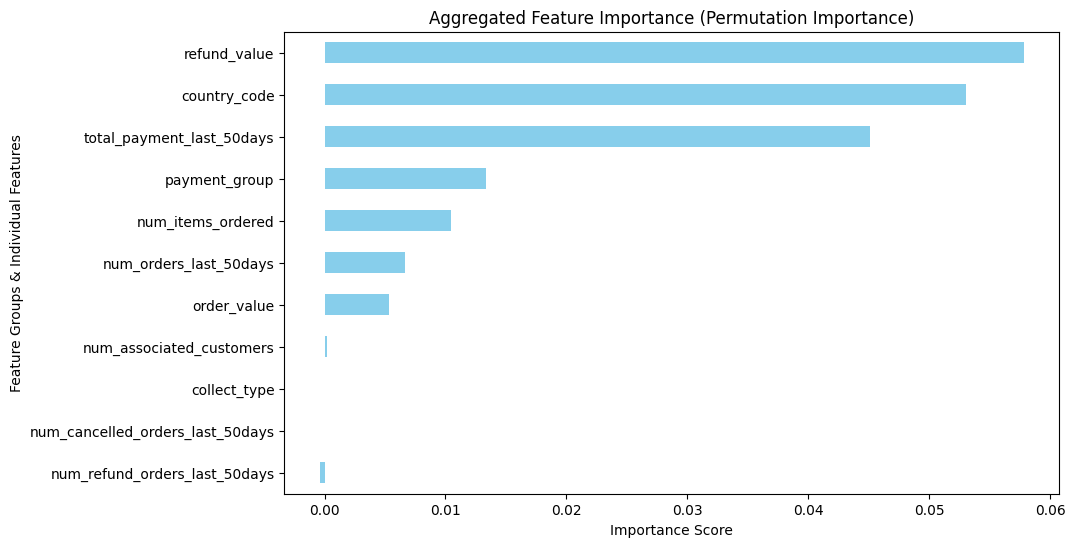

In [39]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(
    dt_best_model, X_train_transformed, y_train, n_repeats=10, random_state=42, n_jobs=2
)

# Extract feature names and importances
feature_names = X_train_transformed.columns
importances_mean = result.importances_mean

# Convert to DataFrame
importances_df = pd.DataFrame({"Feature": feature_names, "Importance": importances_mean})

# Aggregate importances by their original groups
grouped_importances = {
    "payment_group": importances_df[importances_df["Feature"].str.startswith("payment_group")]["Importance"].sum(),
    "country_code": importances_df[importances_df["Feature"].str.startswith("country_code")]["Importance"].sum(),
    "collect_type": importances_df[importances_df["Feature"].str.startswith("collect_type")]["Importance"].sum(),
}

# Add remaining independent features
for feature in importances_df["Feature"]:
    if not (feature.startswith("payment_group") or feature.startswith("country_code") or feature.startswith("collect_type")):
        grouped_importances[feature] = importances_df[importances_df["Feature"] == feature]["Importance"].values[0]

# Convert to DataFrame for plotting
grouped_importances_df = pd.DataFrame.from_dict(grouped_importances, orient="index", columns=["Importance"])
grouped_importances_df = grouped_importances_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
grouped_importances_df["Importance"].plot(kind="barh", color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature Groups & Individual Features")
plt.title("Aggregated Feature Importance (Permutation Importance)")
plt.gca().invert_yaxis()  # Flip for better visualization
plt.show()


<u>**Observation**</u>

**Refunds are the biggest fraud indicator** 
- `refund_value` and `total_payment_last_50days` are the top features. 
- Fraud is highly linked to refund behavior.

**Country & Payment Methods Matter** 
- `country_code` and `payment_group` show fraud varies by region and payment type.

**Order Behavior Plays a Role** 
- `num_orders_last_50days`, `num_items_ordered`, and `order_value` affect fraud risk. 
- `num_associated_customers` has low impact.

**Collect Type is Not Important** 
- Minimal influence, suggesting order collection method isn’t a key fraud factor.

<hr>

# 🚀 **Fraud Detection Project - Key Conclusions & Insights**  

#### **1️⃣ Fraud Detection Focuses on Recall**  
- Since fraud cases are rare but **high-risk**, **recall (True Positive Rate)** is prioritized over accuracy.  
- A model with high accuracy but low recall is **not useful**—it means many fraud cases go undetected.  
- Balancing **false positives vs. false negatives** is crucial to avoid blocking legitimate transactions while catching fraud.  

<hr>

#### **2️⃣ Advanced Data Processing** 🔍  
**🔹 Handling Outliers**  
- Fraud transactions often have **unusual order values, payment methods, or customer behavior**.  
- **Techniques Used:** IQR filtering, log transformations, or isolation forests to detect anomalies.  

**🔹 Dealing with Class Imbalance**  
- Fraud cases are usually **less frequent**, making models biased towards non-fraud cases.  
- **Solutions:**  
  - **Resampling techniques:** SMOTE (Synthetic Minority Over-sampling Technique) or undersampling.  
  - **Class weights:** `class_weight='balanced'` in tree-based models.  

<hr>

#### **3️⃣ Model Optimization & Hyperparameter Tuning** 🎯  
**🔹 Avoiding Overfitting**  
- Models trained on massive datasets might **memorize patterns** instead of generalizing.  
- **Solutions:**  
  - Use **Stratified K-Fold Cross-Validation** to maintain class balance.  
  - **Prune Decision Trees** (max_depth, min_samples_split).  
  - Use **Regularization** in Logistic Regression, XGBoost, or Random Forests.  

<hr>

#### **4️⃣ Learning & Using Efficient Tools** 🛠️  
**🔹 Dask for Scaling**  
- Dask allows processing **big datasets in parallel** instead of loading everything into memory.  
- Used Dask **DataFrame** for efficient operations.  

**🔹 MLflow for Experiment Tracking**  
- MLflow helped in tracking **model performance, hyperparameters, and metrics**.  
- Logged **confusion matrices, accuracy, recall, and model artifacts**.  

**🔹 Pipelines for Automation**  
- Preprocessing steps (feature engineering, encoding, scaling) were structured into **pipelines**.  
- Ensures **reproducibility** and faster experimentation.  
<hr>